In [35]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



path = 'MCD_360d_data.csv'



df = pd.read_csv(path)
df['t'] = pd.to_datetime(df['t'])
dates = df['t'].dt.date.unique()
vlines = []


for date in dates:
    for hour, minute in [(8, 0),(13, 30), (20, 0)]:
        ts = pd.Timestamp(year=date.year, month=date.month, day=date.day, hour=hour, minute=minute, tz='UTC')
        vlines.append(dict(
            type="line",
            x0=ts, x1=ts,
            y0=df['l'].min(), y1=df['h'].max(),
            line=dict(color="blue", width=1, dash="dot"),
            layer="below"
        ))


fig = go.Figure(data=[
    go.Candlestick(
        x=df['t'],
        open=df['o'],
        high=df['h'],
        low=df['l'],
        close=df['c'],
        increasing_line_color='green',
        decreasing_line_color='red'
    )
])


fig.update_layout(
    title='Candlestick Chart with 13:30 and 20:00 UTC Lines',
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    shapes=vlines
)

fig.show()

<Figure size 1200x600 with 0 Axes>

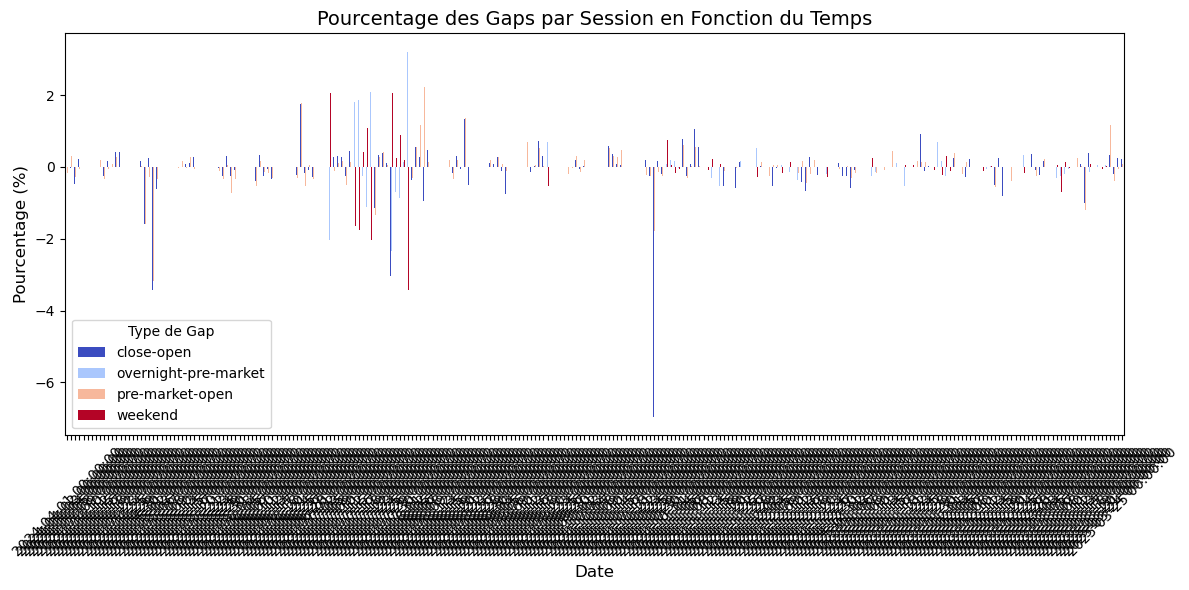

In [36]:
df = pd.read_csv(path)


df['t'] = pd.to_datetime(df['t'])
df['date'] = df['t'].dt.date
df['hour'] = df['t'].dt.hour
df['minute'] = df['t'].dt.minute


def get_session(row):
    if 0 <= row['hour'] < 8:
        return 'overnight'
    elif 8 <= row['hour'] < 13 or (row['hour'] == 13 and row['minute'] < 30):
        return 'pre-market'
    elif (row['hour'] == 13 and row['minute'] >= 30) or (13 < row['hour'] < 20):
        return 'open'
    elif 20 <= row['hour'] < 24:
        return 'after-hours'
    return None

df['session'] = df.apply(get_session, axis=1)


session_prices = df.groupby(['date', 'session']).agg(
    open_price=('o', 'first'),
    close_price=('c', 'last')
).reset_index()



gaps = []
dates = session_prices['date'].unique()
for i, date in enumerate(dates):
    day_data = session_prices[session_prices['date'] == date]
    
    after_hours_price = day_data[day_data['session'] == 'after-hours']['close_price'].values
    overnight_price = day_data[day_data['session'] == 'overnight']['open_price'].values
    premarket_price = day_data[day_data['session'] == 'pre-market']['open_price'].values
    open_price = day_data[day_data['session'] == 'open']['open_price'].values
    
    
    if i > 0: 
        prev_date = dates[i - 1]
        prev_day_data = session_prices[session_prices['date'] == prev_date]
        prev_close_price = prev_day_data[prev_day_data['session'] == 'open']['close_price'].values
        
        if len(prev_close_price) > 0 and len(open_price) > 0:
            close_open_gap = (open_price[0] - prev_close_price[0]) / prev_close_price[0] * 100
            gaps.append({'date': date, 'gap_type': 'close-open', 'gap_percent': close_open_gap, 'x': date, 'y': open_price[0]})
    
    
    if len(after_hours_price) > 0:
        if i + 1 < len(dates): 
            next_date = dates[i + 1]
            next_day_data = session_prices[session_prices['date'] == next_date]
            next_overnight_price = next_day_data[next_day_data['session'] == 'overnight']['open_price'].values
            
            if len(next_overnight_price) > 0:
                weekend_gap = (next_overnight_price[0] - after_hours_price[0]) / after_hours_price[0] * 100
                gaps.append({'date': next_date, 'gap_type': 'weekend', 'gap_percent': weekend_gap, 'x': next_date, 'y': next_overnight_price[0]})
    

    if len(overnight_price) > 0 and len(premarket_price) > 0:
        overnight_premarket_gap = (premarket_price[0] - overnight_price[0]) / overnight_price[0] * 100
        gaps.append({'date': date, 'gap_type': 'overnight-pre-market', 'gap_percent': overnight_premarket_gap, 'x': date, 'y': premarket_price[0]})
    

    if len(premarket_price) > 0 and len(open_price) > 0:
        premarket_open_gap = (open_price[0] - premarket_price[0]) / premarket_price[0] * 100
        gaps.append({'date': date, 'gap_type': 'pre-market-open', 'gap_percent': premarket_open_gap, 'x': date, 'y': open_price[0]})


gaps_df = pd.DataFrame(gaps)
gaps_df['date'] = pd.to_datetime(gaps_df['date']) 
gaps_df = gaps_df.sort_values(by='date')

gaps_df = gaps_df[(gaps_df['gap_percent'] <= 20) & (gaps_df['gap_percent'] >= -20)] ### outlier pour mstr et nvdia

pivot_data = gaps_df.pivot(index='date', columns='gap_type', values='gap_percent')

plt.figure(figsize=(12, 6))
pivot_data.plot(kind='bar', stacked=False, figsize=(12, 6), colormap='coolwarm')

plt.title("Pourcentage des Gaps par Session en Fonction du Temps", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Pourcentage (%)", fontsize=12)
plt.legend(title="Type de Gap", fontsize=10)
plt.xticks(rotation=45, fontsize=10) 
plt.tight_layout()
plt.show()

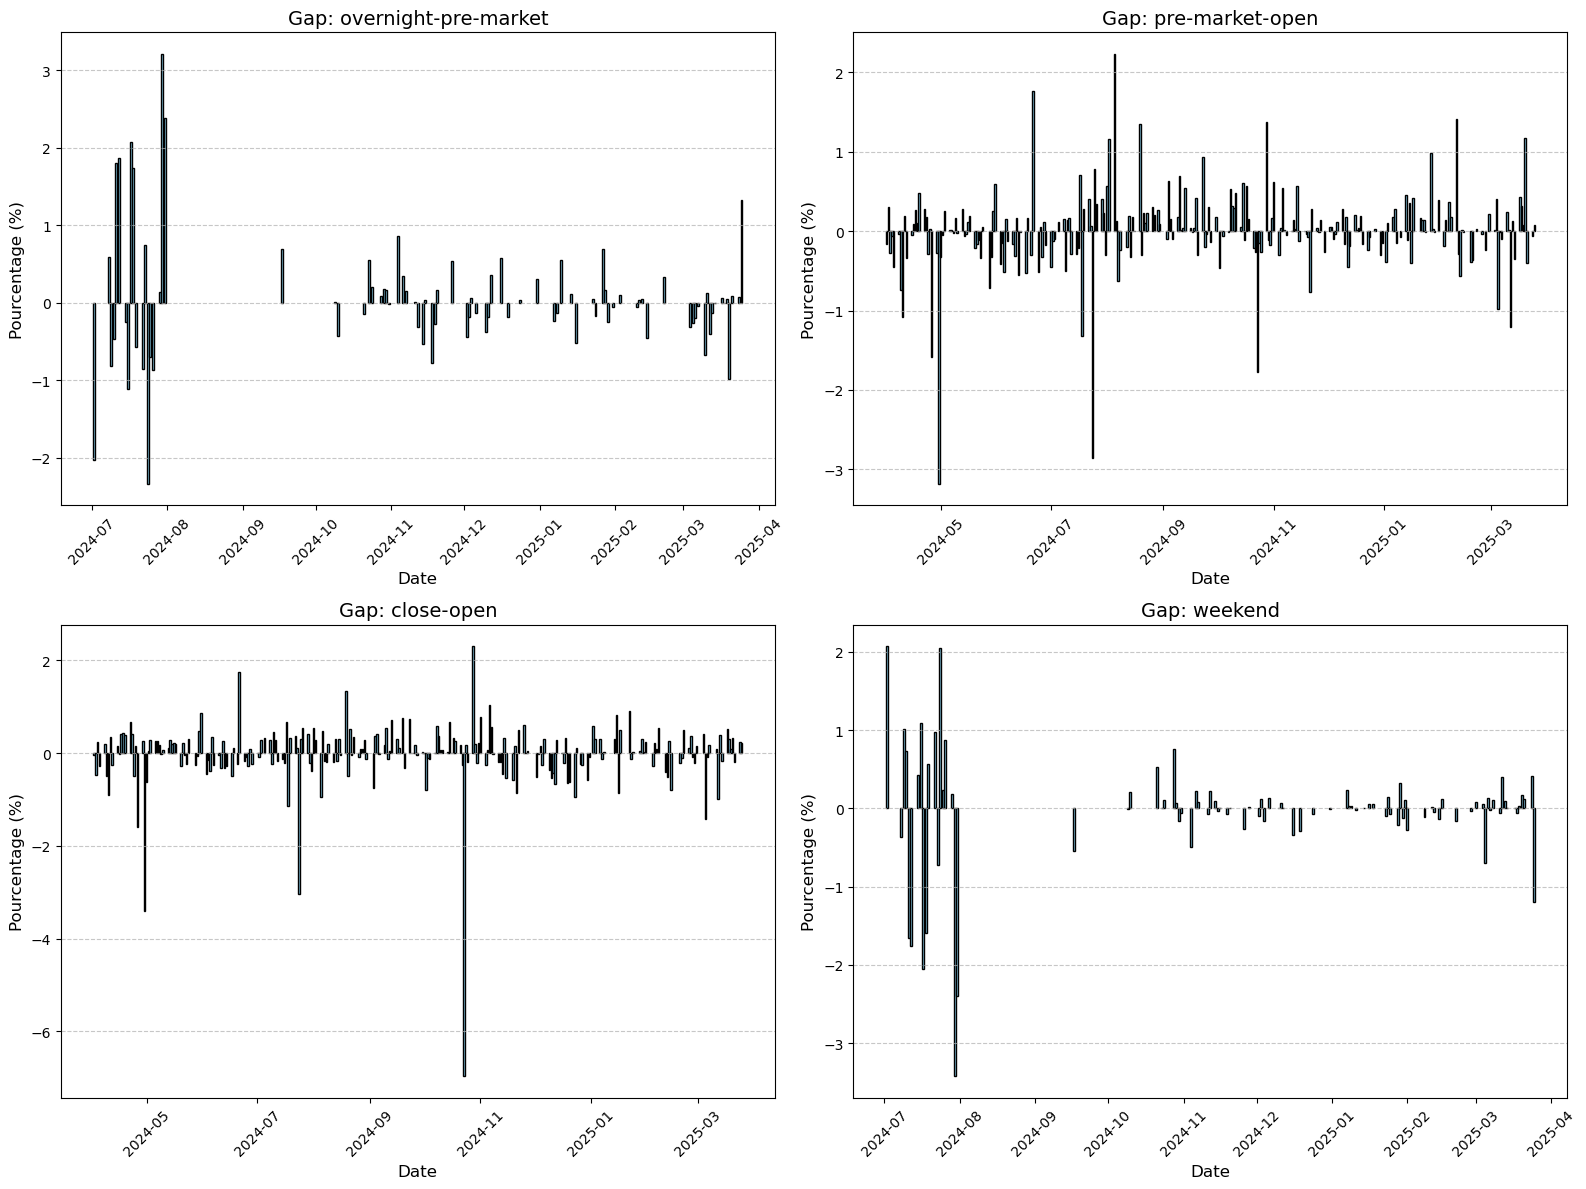

In [37]:
gap_types = ['overnight-pre-market', 'pre-market-open', 'close-open', 'weekend']

plt.figure(figsize=(16, 12))

for i, gap_type in enumerate(gap_types, 1):
    plt.subplot(2, 2, i)
    gap_data = gaps_df[gaps_df['gap_type'] == gap_type]
    plt.bar(gap_data['date'], gap_data['gap_percent'], color='skyblue', edgecolor='black')
    plt.title(f"Gap: {gap_type}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Pourcentage (%)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

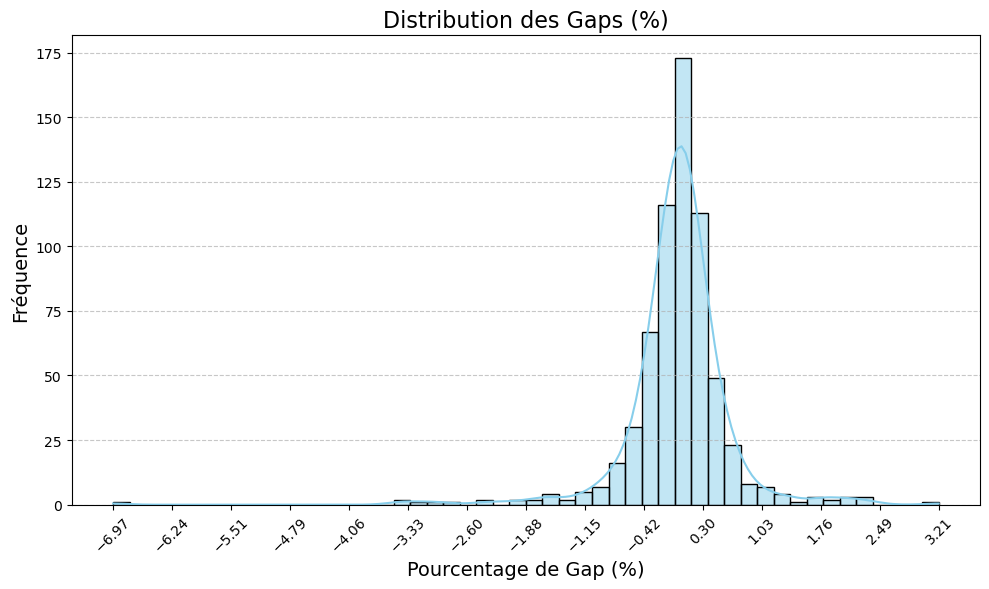

In [38]:
import numpy as np
# Distribution des gaps
plt.figure(figsize=(10, 6))
sns.histplot(gaps_df['gap_percent'], bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution des Gaps (%)", fontsize=16)
plt.xlabel("Pourcentage de Gap (%)", fontsize=14)
plt.ylabel("Fréquence", fontsize=14)

# Ajout de plus de graduations sur l'axe des abscisses
gap_min = gaps_df['gap_percent'].min()
gap_max = gaps_df['gap_percent'].max()
plt.xticks(ticks=np.linspace(gap_min, gap_max, num=15), fontsize=10, rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()